# GraphNeural Network - Linkage Prediction

### CORA data set-content introduction

- Sample features, labels, adjacency matrix


The data set has a total of 2708 sample points. Each sample point is a scientific paper. All sample points are divided into 8 categories. The categories are 1) Case-based; 2) Genetic algorithm; 3) Neural network; 4) Probabilistic methods; 5) reinforcement learning; 6) rule learning; 7) theory

Each paper is represented by a 1433-dimensional word vector, so each sample point has 1433 features. Each element of the word vector corresponds to a word, and this element has only two values, 0 or 1. Take 0 to indicate that the word corresponding to the element is not in the paper, and 1 to indicate it is in the paper. All the words come from a dictionary with 1433 words.

Each paper cited at least one other paper, or was cited by other papers, that is, there is a connection between the sample points, and no sample point is completely disconnected from other sample points. If the sample points are regarded as points in the graph, then this is a connected graph and there are no isolated points.

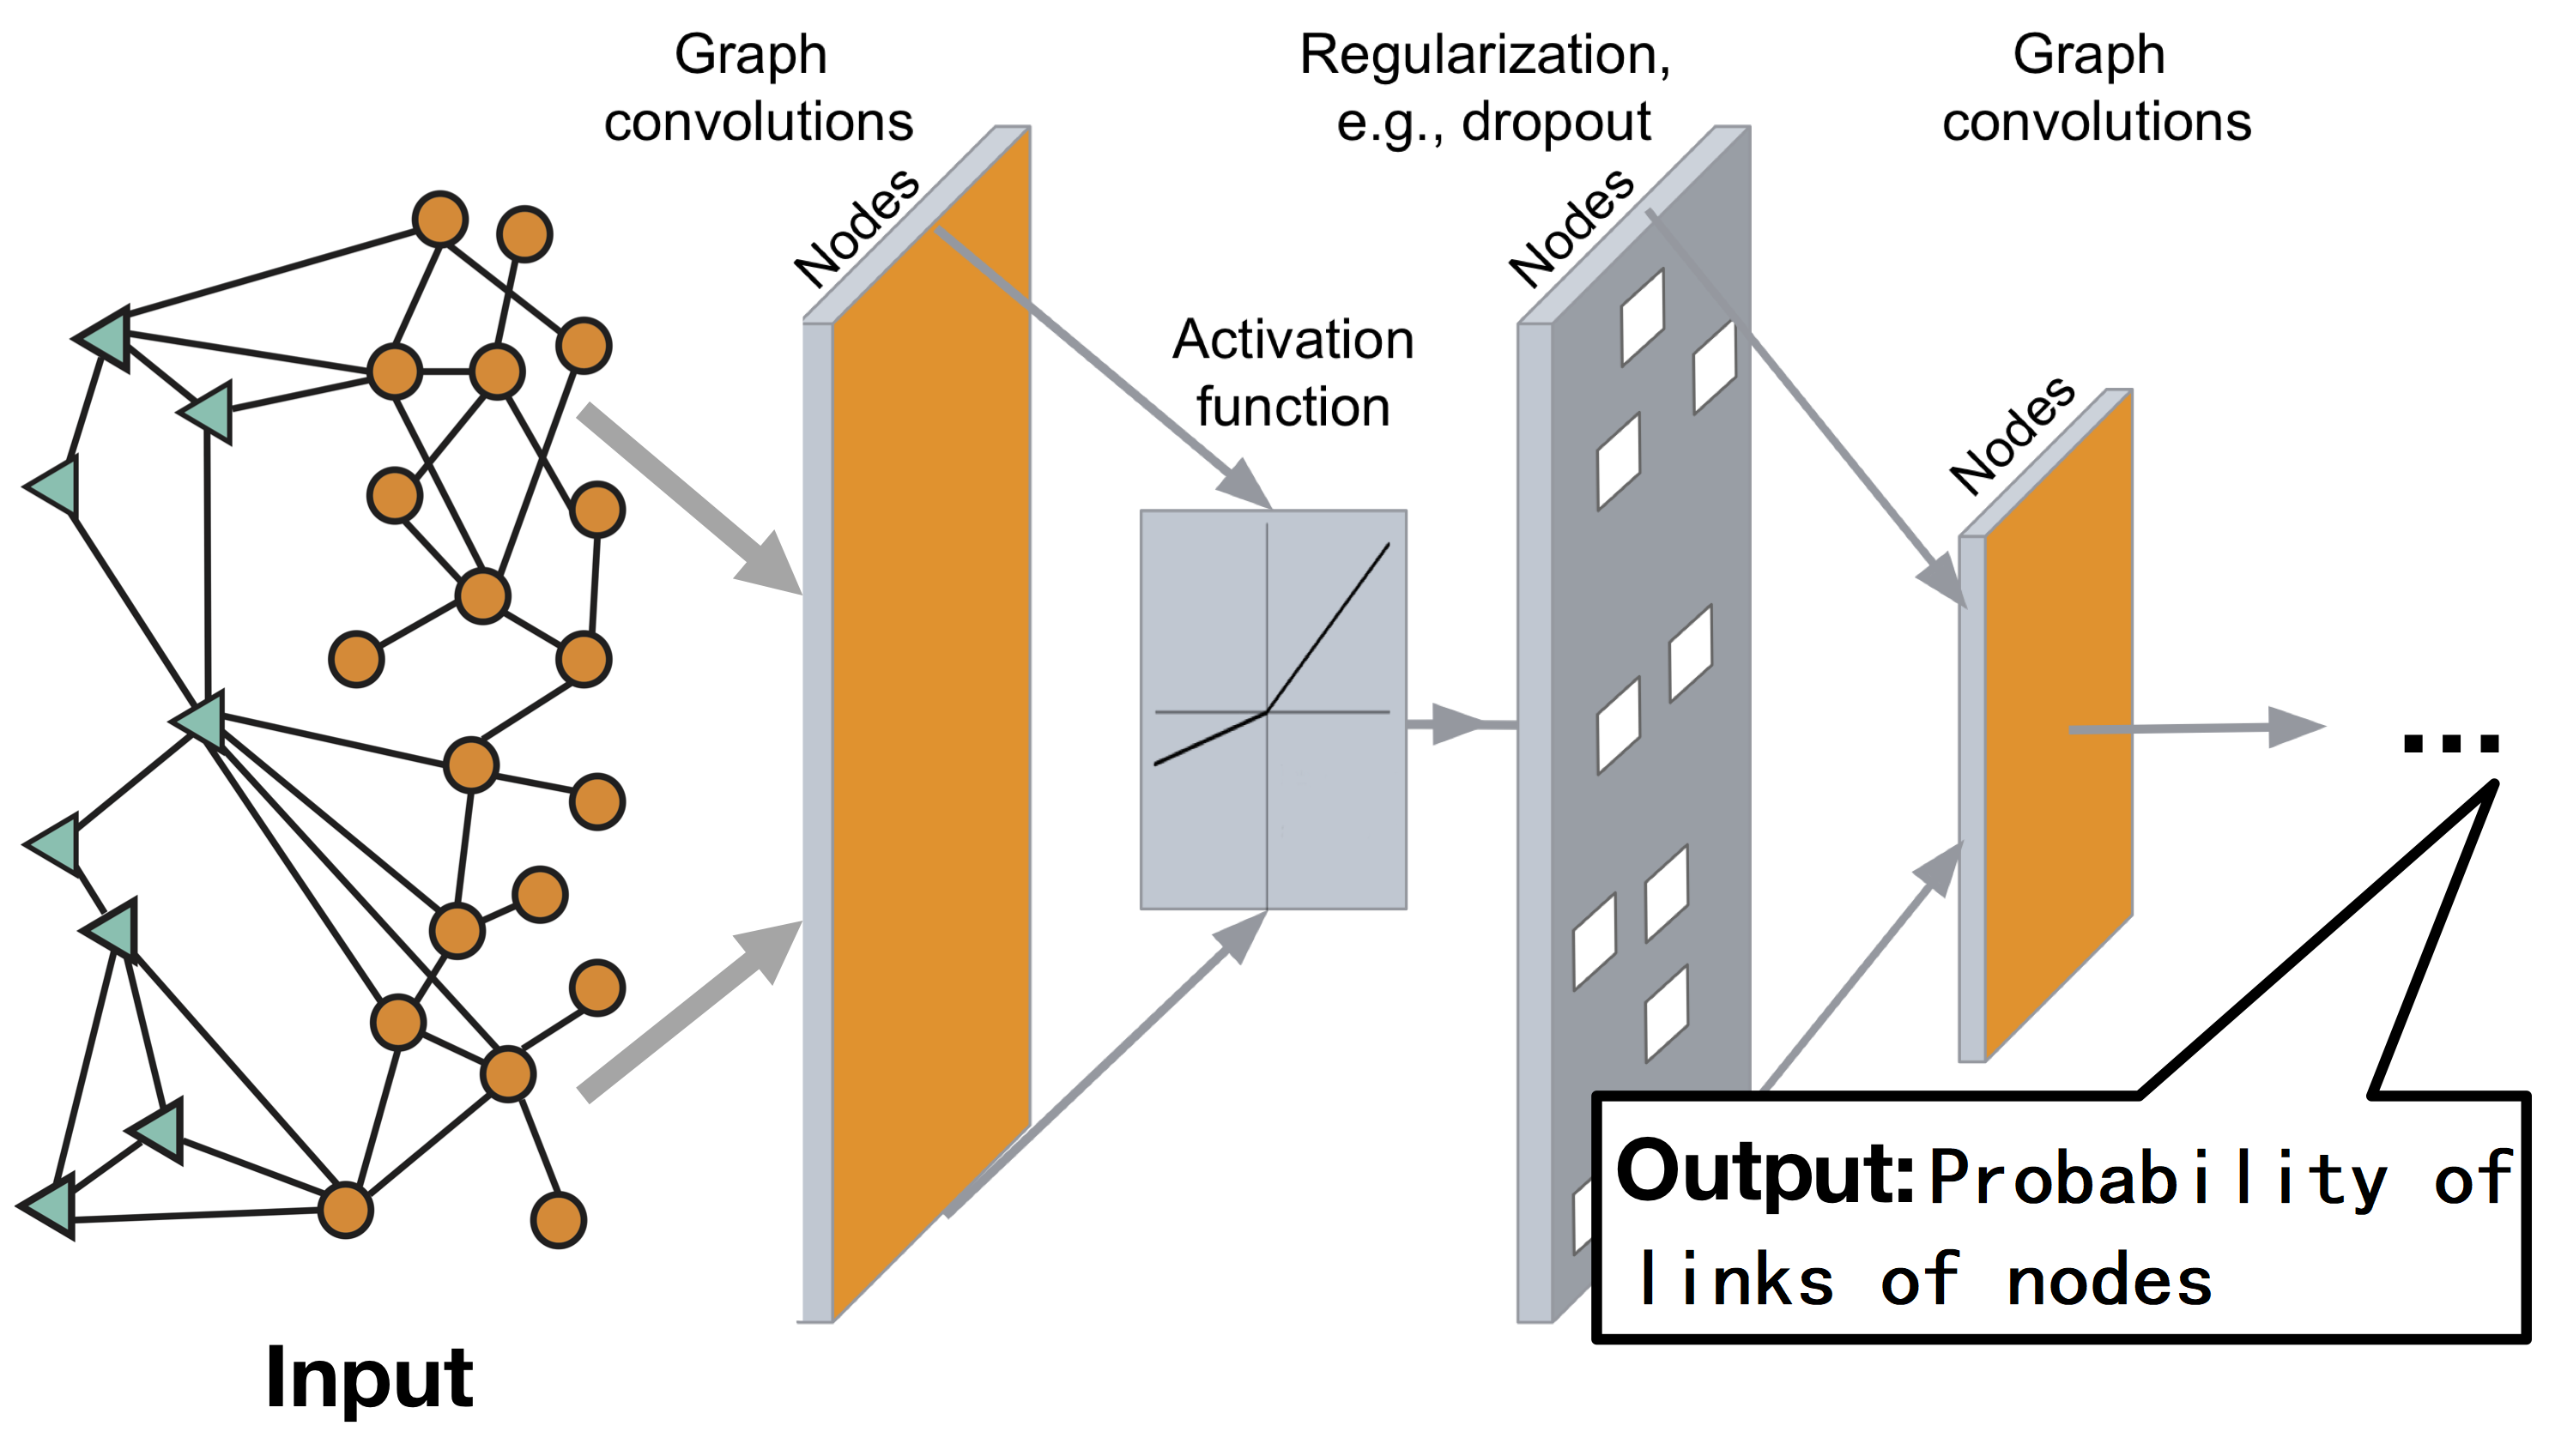

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import torch
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ! wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
# ! tar -xf cora.tgz

# ! ls cora

In [3]:
raw_data = pd.read_csv('cora/cora.content',sep = '\t',header = None)

In [4]:
raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


- file format

There are three files in the downloaded compressed package, namely cora.cites, cora.content, and README.

README is an introduction to the data set; cora.content is the unique information of all papers; cora.cites is the citation record between papers.

There are 2708 rows in cora.content, and each row represents a sample point, that is, a paper. As shown below, each line consists of three parts, which are the number of the paper, such as 31336; the word vector of the paper, a binary with 1433 bits; and the category of the paper, such as Neural_Networks.

In [5]:
print('Essay id：', raw_data[0][0])

Essay id： 31336


In [6]:
# The bag of words vector of the first paper
raw_data.iloc[0:1, 1:1434]

,1,2,3,4,5,6,7,8,9,10,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
print('Number of words appearing in the paper:', raw_data.iloc[0:1, 1:1434].sum(1)[0])

Number of words appearing in the paper: 20


In [8]:
print('thesis type:', raw_data.iloc[0, 1434])

thesis type: Neural_Networks


Cora.cites has a total of 5429 lines, each line has two paper numbers, which means that the first numbered paper is written first, and the second numbered paper quotes the first numbered paper. As follows:

In [9]:
# Paper cited data
raw_data_cites = pd.read_csv('cora/cora.cites',sep = '\t',header = None)
raw_data_cites[:10]

,0,1
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
5,35,1103985
6,35,1109199
7,35,1112911
8,35,1113438
9,35,1113831


### Data Preprocess

#### Preprocess Functions:

In [10]:
def encode_onehot(labels):
    """
    convert labels to onehot
    """
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

##### 1） Get Features

In [11]:
idx_features_labels = np.array(raw_data)

# Take the bag-of-words vector of each paper as the feature vector of each article and store it in a sparse matrix format
features = sp.csr_matrix(idx_features_labels[:, 1: -1], dtype=np.float32)

###### 2） Get Edges

In [12]:
# Take out the id of each paper
idx = np.array(idx_features_labels[:, 0], dtype=np.int32)

# Mapping the paper id to [0, 2708 this interval]
idx_map = {j: i for i, j in enumerate(idx)} 

# cites data converted to numpy vector
edges_unordered = np.array(raw_data_cites)

In [13]:
raw_data_cites.head(10)

,0,1
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
5,35,1103985
6,35,1109199
7,35,1112911
8,35,1113438
9,35,1113831


In [14]:
#### check directed or undirected edges ?

In [15]:
raw_data_cites[(raw_data_cites[0]==35)&(raw_data_cites[1]==1033)]

,0,1
0,35,1033


In [16]:
raw_data_cites[(raw_data_cites[1]==35)&(raw_data_cites[0]==1033)]

,0,1


In [17]:
##### edges are directed , which means  one-way-connected

In [18]:
# covert cities to numpy vector
edges_unordered = np.array(raw_data_cites)

# Map the id in the cites data to the interval [0, 2708]
edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                 dtype=np.int32).reshape(edges_unordered.shape)



##### 3) Get the label

In [19]:
label = encode_onehot(idx_features_labels[:, -1])

##### 4) Process Adjacent Matric 

In [20]:
# Store the citation relationship between papers in a sparse matrix format

## this is the directed adj
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(label.shape[0], label.shape[0]),
                    dtype=np.float32)

features = torch.FloatTensor(np.array(features.todense()))

# covert to undirected adjacency_matrix
adj = nx.adjacency_matrix(nx.convert_matrix.from_scipy_sparse_matrix(adj))

# Save the original adjacency matrix for later evaluation
adj_orig = adj.copy()

# to remove the one value on the diagnoal, because node cannot connect to itself
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

##### 5) Generate and process train, val and test data, and mask val and test data in train data.

In [21]:
def sparse_to_tuple(sparse_mx):
    """
    Convert scipy sparse matrix into triples, including (coordinates, values, matrix shape)
    """
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def mask_test_edges(adj):
    """
    The data set is divided, and 10% of the edges are randomly used as the test set
    """

    # Remove the value on the diagonal
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    # get the upper triangel values only
    adj_triu = sp.triu(adj)
    
    # get edege list
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    
    
    # undirected edge, for example, include 5->3, 3 -> 5
    edges_all = sparse_to_tuple(adj)[0]
    
    
    # val and test dataset size
    num_test = int(np.floor(edges.shape[0] / 10.))
    num_val = int(np.floor(edges.shape[0] / 20.))

    
    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    
    # get edge for train,test,val but they're connected.but have to sample unconnected edges for test and val
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
    
    # function to 
    def ismember(created_edges,all_edges , tol=5):
        rows_close = np.all(np.round(created_edges - all_edges[:, np.newaxis], tol) == 0, axis=-1)
        return np.any(rows_close)

    # sample unconnected edges for test [fake edge] and make sure it doesn't exit in test dataset, but can in val and train dataset
    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], edges_all):
            continue
        if test_edges_false:
            if ismember([idx_j, idx_i], np.array(test_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(test_edges_false)):
                continue
        test_edges_false.append([idx_i, idx_j])
    
    # sample unconnected edges for val [fake edge] and make sure it doestn't exit in train and val dataset
    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        idx_i = np.random.randint(0, adj.shape[0])
        idx_j = np.random.randint(0, adj.shape[0])
        if idx_i == idx_j:
            continue
        if ismember([idx_i, idx_j], train_edges):
            continue
        if ismember([idx_j, idx_i], train_edges):
            continue
        if ismember([idx_i, idx_j], val_edges):
            continue
        if ismember([idx_j, idx_i], val_edges):
            continue
        if val_edges_false:
            if ismember([idx_j, idx_i], np.array(val_edges_false)):
                continue
            if ismember([idx_i, idx_j], np.array(val_edges_false)):
                continue
        val_edges_false.append([idx_i, idx_j])

    assert ~ismember(test_edges_false, edges_all)
    assert ~ismember(val_edges_false, edges_all)
    assert ~ismember(val_edges, train_edges)
    assert ~ismember(test_edges, train_edges)
    assert ~ismember(val_edges, test_edges)

    data = np.ones(train_edges.shape[0])

    # reconstruture the adj matrix, only including train edge only
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T # convert toundirected matrix

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false

In [22]:
# the input adj is undirected
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
# the output adjs are directed

In [23]:
adj = adj_train.copy()

In [24]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert scipy sparse matrix to torch sparse matrix
    """
    # Take out the coordinates of each non-zero value in the matrix
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    
    # Convert coordinates to numpy format
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    
    # Take out the value in the matrix and convert it to torch format
    values = torch.from_numpy(sparse_mx.data)
    
    # Get the shape of the matrix and convert it to torch format
    shape = torch.Size(sparse_mx.shape)
    
    # Return sparse matrix in torch format
    return torch.sparse.FloatTensor(indices, values, shape)

def preprocess_graph(adj):
    """
    Graph preprocessing, including normalization operations
    """
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_mx_to_torch_sparse_tensor(adj_normalized)

In [25]:
# Graph preprocessing, including normalization operations
adj_norm = preprocess_graph(adj)

In [26]:
adj_train

<2708x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 8976 stored elements in Compressed Sparse Row format>

In [27]:
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = torch.FloatTensor(adj_label.toarray())

In [28]:
adj_label

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [29]:
adj.sum()

8976.0

In [30]:
# # Calculate the ratio between reference and reference for subsequent training
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
# Regular item, used for follow-up training
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [31]:
pos_weight

815.9857397504456

In [32]:
norm

0.5006127558064347

### Model Construction

In [33]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
     A simple implementation of graph convolution, please refer to the paper https://arxiv.org/abs/1609.02907
     ...
     Attributes
     ----------
     in_features: int
         The size of the image convolution input feature vector, namely $|H^{(l)}|$
     out_features: int
         The size of the image convolution output vector, namely $|H^{(l+1)}|$
     bias: bool
         Whether to use the offset vector, the default is True, that is, the default is to use the offset vector
     weight: Parameter
         Trainable parameters in graph convolution,
        
     Methods
     -------
     __init__(self, in_features, out_features, bias=True)
         The constructor of the graph convolution, defines the size of the input feature, the size of the output vector, whether to use offset, parameters
     reset_parameters(self)
         Initialize the parameters in the graph convolution
     forward(self, input, adj)
         Forward propagation function, input is the feature input, and adj is the transformed adjacency matrix $N(A)=D^{-1}\tilde{A}$. Completing the calculation logic of forward propagation, $N(A) H^{(l)} W^{(l)}$
     __repr__(self)
         Refactored class name expression
     """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        
        # create Weight and Bias trainable parameters
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # standard weight to be uniform
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        # H * W
        support = torch.mm(input, self.weight)
        
        # N(A) * H * W # Addition aggregation by multiplying
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            # N(A) * H * W + b
            return output + self.bias
        else:
            return output

#     def __repr__(self):
#         return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [34]:

class GCN4Link(nn.Module):
    '''
     Two-layer graph convolutional neural network model
     ...
     Attributes
     ----------
     n_feat: int
         The size of the input feature vector of the graph network
     n_hid: int
         Hidden layer dimension size
     n_class: int
         Number of classifier categories
     dropout: float
         dropout rate

     Methods
     -------
     __init__(self, n_feat, n_hid, n_class, dropout)
         Two-layer graph convolutional neural network constructor, defining the dimension of the input feature, the dimension of the hidden layer, the number of classifier categories, and the dropout rate
     forward(self, x, adj)
         Forward propagation function, x is the input feature of the graph network, adj is the adjacency matrix that has been transformed $N(A)$
     '''

    def __init__(self, n_feat, n_hid, dropout):
        super(GCN4Link, self).__init__()
        # Define the first layer of graph convolutional layer, the input is the graph network feature, the dimension is n_feat, and the output dimension is n_hid
        self.gc1 = GraphConvolution(n_feat, n_hid)
        # Define the second layer of graph convolutional layer, the input dimension is n_hid, the output dimension is n_hid
        self.gc2 = GraphConvolution(n_hid, n_hid, dropout)
        # Define familiar dropout rate
        self.dropout = dropout

    def forward(self, x, adj):
        # The output of the first convolutional layer and the output of the nonlinear activation function Relu
        x = F.relu(self.gc1(x, adj))
        # dropout
        x = F.dropout(x, self.dropout, training=self.training)
        # The output of the second convolutional layer is mapped to the output category dimension
        x = self.gc2(x, adj)

        # dropout increases model robustness
        x = F.dropout(x, self.dropout, training=self.training)

        # Calculate the probability of an edge between every two nodes based on the dot product
        adj_preds = torch.mm(x, x.t())
        return adj_preds

In [35]:
# Training hyperparameter configuration
class Args:
    no_cuda = False
    seed = 42  
    epochs = 100    
    lr = 0.01        
    hidden =  128       
    dropout = 0.1       

In [36]:
from sklearn.metrics import average_precision_score

def get_acc_score(emb, adj_orig, edges_pos, edges_neg):
    """
     Evaluate the accuracy of prediction
     """
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    adj_rec = np.dot(emb, emb.T)
    # Get the prediction score of each positive example
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])
    # Get the prediction score of each negative example
    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])
    # Combine prediction scores and standard answers, and use the correct rate evaluator evaluation indicator that comes with sklearn.metrics
    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    acc_score = average_precision_score(labels_all, preds_all)

    return acc_score

In [37]:
from torch import optim
import time

args = Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
# Initialize the model
model = GCN4Link(n_feat=features.shape[1],
        n_hid=args.hidden,
        dropout=args.dropout)

# 定义模型优化器
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [38]:
# 开始训练
for epoch in range(args.epochs):
    t = time.time()
    _ = model.train()
    optimizer.zero_grad()
    # Forward propagation
    preds = model(features, adj_norm)
    # Use binary_cross_entropy to calculate loss, use the previously calculated norm and pos_weight to adjust the number of reference edges and non-reference edges
    loss = norm * F.binary_cross_entropy_with_logits(preds, adj_label, pos_weight=torch.tensor(pos_weight))

    # Backpropagation
    loss.backward()
    cur_loss = loss.item()
    # Update parameters 
    optimizer.step()

    # Test the effect of the model on the validation set
    acc_curr = get_acc_score(preds.data.numpy(), adj_orig, val_edges, val_edges_false)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss),
          "accurancy=", "{:.5f}".format(acc_curr),
          "time=", "{:.5f}".format(time.time() - t)
          )

print("Optimization Finished!")

Epoch: 0001 train_loss= 0.74990 accurancy= 0.50000 time= 0.60338
Epoch: 0002 train_loss= 1.18018 accurancy= 0.50000 time= 0.56150
Epoch: 0003 train_loss= 0.71873 accurancy= 0.50000 time= 0.55252
Epoch: 0004 train_loss= 0.85711 accurancy= 0.50000 time= 0.52759
Epoch: 0005 train_loss= 0.77732 accurancy= 0.50000 time= 0.52958
Epoch: 0006 train_loss= 0.76787 accurancy= 0.50000 time= 0.49767
Epoch: 0007 train_loss= 0.77321 accurancy= 0.50000 time= 0.59242
Epoch: 0008 train_loss= 0.77712 accurancy= 0.50000 time= 0.54255
Epoch: 0009 train_loss= 0.77899 accurancy= 0.50000 time= 0.57546
Epoch: 0010 train_loss= 0.77858 accurancy= 0.50000 time= 0.52260
Epoch: 0011 train_loss= 0.77814 accurancy= 0.50000 time= 0.53158
Epoch: 0012 train_loss= 0.77615 accurancy= 0.50000 time= 0.54355
Epoch: 0013 train_loss= 0.77410 accurancy= 0.50000 time= 0.49667
Epoch: 0014 train_loss= 0.77147 accurancy= 0.50000 time= 0.54853
Epoch: 0015 train_loss= 0.76656 accurancy= 0.50000 time= 0.52759
Epoch: 0016 train_loss= 0

In [39]:
_ = model.eval()
# Test the model effect on the test set
acc = get_acc_score(preds.data.numpy(), adj_orig, test_edges, test_edges_false)
print('Test accurancy: ' + str(acc))

Test accurancy: 0.7227544350253599
